In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

commonlit_lm		       test.csv        train_duo.csv
commonlitreadabilityprize.zip  train-orig.csv
sample_submission.csv	       train.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009
...,...,...,...,...,...,...
2844,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2845,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2846,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2847,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [6]:
train_df[train_df['excerpt'].str.contains('Robin Hood')]

,id,url_legal,license,excerpt,target,standard_error
231,21ea485fb,NaN,NaN,A little within the wood there was a fair cast...,-1.302688,0.450399
233,a04741371,NaN,NaN,"The king dwelt for many months in Nottingham, ...",-0.714009,0.506864
234,5cb5ab998,NaN,NaN,"When they drew near Nottingham, all the people...",-1.541347,0.478166
235,622f6215e,NaN,NaN,About this time there was living in Nottingham...,-2.054284,0.538084


In [7]:
train_df[train_df['id'] == '21ea485fb']['excerpt'].values

array(['A little within the wood there was a fair castle, with a double moat, and surrounded by stout walls. Here dwelt that noble knight, Sir Richard Lee, to whom Robin Hood had lent the four hundred pounds to redeem his land.\nHe saw the little company of outlaws fighting their way along, so he hastened to call them to come and take shelter in his castle.\n"Welcome art thou, Robin Hood! Welcome!" he cried, as he led them in. "Much I thank thee for thy comfort and courtesy and great kindness to me in the forest. There is no man in the world I love so much as thee. For all the proud Sheriff of Nottingham, here thou shalt be safe!—Shut the gates, and draw the bridge, and let no man come in!" he shouted to his retainers. "Arm you well; make ready; guard the walls! One thing, Robin, I promise thee: here shalt thou stay for twelve days as my guest, to sup, and eat, and dine."\nSwiftly and readily tables were laid and cloths spread, and Robin Hood and his merry men sat down to a good meal.'

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

1304   -3.351956
1305   -3.351956
Name: target, dtype: float64

### Normalize

In [9]:
train_df['target'].describe()

count    2849.000000
mean       -0.958304
std         1.032874
min        -3.676268
25%        -1.686487
50%        -0.908395
75%        -0.203188
max         1.711390
Name: target, dtype: float64

In [10]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_target_mean, train_target_std

(-0.9583035525693224, 1.0328738358133043)

In [11]:
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [12]:
train_df['normalized_target'].describe()

count    2.849000e+03
mean    -1.396644e-16
std      1.000000e+00
min     -2.631458e+00
25%     -7.050076e-01
50%      4.831964e-02
75%      7.310820e-01
max      2.584724e+00
Name: normalized_target, dtype: float64

In [13]:
train_df['normalized_target_check'] = train_df['normalized_target'] * train_target_std + train_target_mean

In [14]:
train_df.head(30)

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598374,-0.340259
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598374,-0.340259
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598374,-0.340259
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598374,-0.340259
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0.598374,-0.340259
5,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0.622468,-0.315372
6,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0.366149,-0.580118
7,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.092664,-1.054013
8,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.092664,-1.054013
9,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,1.167133,0.247197


In [15]:
# !pip install seaborn

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

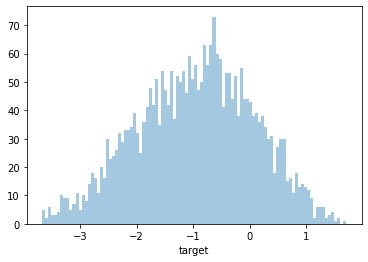

In [17]:
sns.distplot(train_df['target'],bins=100,kde=False)

### Configuration

In [18]:
import yaml

In [19]:
class CONFIG():
    batch_size = 12
    max_len = 256
    num_workers = 4
    epochs = 30
    pretrained_transformers_model = f'microsoft/deberta-base'
    target_field = 'normalized_target'

In [20]:
cfg = CONFIG()
cfg.model_name = 'microsoft/deberta-base'
cfg.num_folds = 6

In [21]:
cfg.train_target_std = float(train_target_std)
cfg.train_target_mean = float(train_target_mean)

In [22]:
# assert Path(cfg.pretrained_transformers_model).exists()

In [23]:
vars(cfg)

{'model_name': 'microsoft/deberta-base',
 'num_folds': 6,
 'train_target_std': 1.0328738358133043,
 'train_target_mean': -0.9583035525693224}

In [24]:
!mkdir {MODELS_PATH}/microsoft

mkdir: cannot create directory ‘/home/commonlit/models/microsoft’: File exists


In [25]:
with open(f'{MODELS_PATH}/{cfg.model_name}.yaml', 'w') as file:
    documents = yaml.dump(vars(cfg), file)

### Prepare Cross Validation

In [26]:
target = train_df[cfg.target_field].to_numpy()

In [27]:
num_bins = int(np.floor(np.log2(len(train_df))) + 1)
train_df.loc[:, 'bins'] = pd.cut(train_df[cfg.target_field], bins=num_bins, labels=False)

In [28]:
train_df[[cfg.target_field, 'bins']].groupby(['bins']).agg(['mean', 'count'])

normalized_target      
                  mean count
bins                        
0            -2.375318    44
1            -1.947058    79
2            -1.518371   172
3            -1.111549   269
4            -0.672601   367
5            -0.235351   420
6             0.203272   485
7             0.627869   411
8             1.053681   312
9             1.470757   184
10            1.875569    83
11            2.283016    23

In [29]:
kf = StratifiedKFold(n_splits=cfg.num_folds)

In [30]:
for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
    train_df.loc[v_, 'kfold'] = i

In [31]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

In [32]:
train_df = train_df.drop('bins', axis=1)

In [33]:
train_df

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598374,-0.340259,0
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.598374,-0.340259,0
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598374,-0.340259,0
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.598374,-0.340259,0
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0.598374,-0.340259,0
...,...,...,...,...,...,...,...,...,...
2844,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,2.584724,1.711390,5
2845,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,1.111248,0.189476,5
2846,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,1.174890,0.255209,5
2847,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,0.719376,-0.215279,5


In [34]:
train_df[[cfg.target_field, 'kfold']].groupby(['kfold']).agg(['mean', 'count'])

normalized_target      
                   mean count
kfold                        
0              0.000735   475
1              0.017731   475
2              0.012772   475
3             -0.020948   475
4             -0.005265   475
5             -0.005035   474

In [35]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[7, 3, 10, 2, 8, 4, 5, 1, 9, 0, 6, 11]

In [36]:
train_df['normalized_target'].mean()

-1.396644198054251e-16

### Metrics

In [37]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [38]:
a = np.random.rand(10)
b = np.random.rand(10)

In [39]:
rmse_score(a, b), rmse_score_2(a, b)

(0.46895463509667196, 0.46895463509667196)

### Prepare train test split

In [40]:
def create_split(fold = [1]):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df['excerpt'].values
    valid_target = valid_df[cfg.target_field].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df['excerpt'].values
    train_target = training_df[cfg.target_field].values
    return train_text, train_target, valid_text, valid_target

In [41]:
train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2374, 475)

### Prepare Tokenizers

In [42]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
# tokenizer.save_pretrained(cfg.save_dir)

In [43]:
encoded_dict = tokenizer(train_df['excerpt'].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True,
                                return_token_type_ids=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

'[CLS]When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowsho

In [44]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [45]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [46]:
encoded_dict['input_ids'].shape

torch.Size([1, 256])

In [47]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, max_len=128):
        self.excerpt = text
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return InputFeatures(input_ids=convert_to_list(encode['input_ids']),
                      attention_mask=convert_to_list(encode['attention_mask']),
                      label=torch.tensor(self.target[idx]))
    
    def __len__(self):
        return len(self.excerpt)

In [48]:
def create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, cfg.max_len)
    return train_ds, valid_ds

In [49]:
# encode.keys(), target.shape, encode['input_ids'].shape, encode['attention_mask'].shape

In [50]:
# encode['input_ids'][0].squeeze()

### Model

In [51]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
# ??transformer_model

In [53]:
# dict(transformer_out)['last_hidden_state'].shape

In [54]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [55]:
# sample_layer = nn.Linear(768, 1)

In [56]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [57]:
model_config

DebertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.6.0",
  "type_vocab_size": 0,
  "vocab_size": 50265
}

In [58]:
from torch.nn import functional as F

In [60]:
from transformers import PreTrainedModel
from transformers.models.deberta.modeling_deberta import ContextPooler

In [96]:


class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.drop = nn.Dropout(0.5)
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        num_hidden_layers = 1
        self.pooler = ContextPooler(self.config)
#         self.pooler_linear = nn.Linear(self.config.hidden_size * num_hidden_layers, self.config.hidden_size * num_hidden_layers)
#         self.pooler_activation = nn.Tanh()
        self.layer_norm = nn.LayerNorm(self.config.hidden_size * num_hidden_layers)
        self.out = nn.Linear(self.config.hidden_size * num_hidden_layers, 1)
        self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze(), 
                                                 output_hidden_states=True)
#         x = transformer_out.pooler_output
#         x = transformer_out.last_hidden_state[:, 0, :] # N, C, X
#         x = torch.mean(transformer_out.hidden_states[-2], axis=1)
#         x2 = torch.mean(transformer_out.encoder_hidden_states[-2], axis=1)
#         x = torch.cat([x, x2], axis=1)
#         x = self.pooler(transformer_out.hidden_states[-2])
#         hidden_states = torch.cat(tuple([transformer_out.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
#         x = self.pooler_linear(hidden_states[:,0])
#         x = self.pooler_activation(x)
        x = self.pooler(transformer_out.last_hidden_state)
        x = self.layer_norm(x)
        x = self.drop(x)
        x = self.out(x)
        return x
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [97]:
model = CommonLitModel()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
encoded_dict.token_type_ids.shape

torch.Size([1, 256])

In [99]:
# transformer_model = transformer_model.cpu()
# sample_out = transformer_model(encoded_dict.input_ids.cpu(), encoded_dict.attention_mask.cpu(), encoded_dict.token_type_ids.cpu(), output_hidden_states=True)

In [100]:
transformer_model = model.transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), encoded_dict.token_type_ids.cuda(), output_hidden_states=True)

In [101]:
sample_out.keys()

odict_keys(['last_hidden_state', 'hidden_states'])

In [102]:
sample_out_cat = torch.cat(tuple([sample_out.hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)

In [103]:
sample_out_cat[:, 0].shape

torch.Size([1, 3072])

In [104]:
sample_out.last_hidden_state.shape

torch.Size([1, 256, 768])

In [105]:
sample_out_cat = model.cuda().pooler(sample_out.last_hidden_state.cuda())

In [106]:
sample_out_cat.shape

torch.Size([1, 768])

### Training

In [107]:
import wandb

In [108]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

loss_fct = nn.MSELoss()

def loss_fct(yhat, y):
    return torch.sqrt(criterion(yhat, y))

In [109]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='mse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=5e-5
    )
    return training_args

In [110]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'mse': mean_squared_error(logits, labels), 'rmse': rmse_score_2(logits, labels)}

In [111]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [112]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss

In [136]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

In [114]:
%%time

from transformers import EarlyStoppingCallback

bin_step = 1
bestmodels = []
eval_rmses = []
for i in range(0, cfg.num_folds, bin_step):
    train_bins = bin_list[i:i+bin_step]
    print('train_bins', f'{i}: {train_bins}')
    tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
    train_text, train_target, valid_text, valid_target = create_split([i])
    train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)
    training_args = create_training_args(i)
    model = CommonLitModel()
    wandb.init(project=f"commonlit_{cfg.model_name.replace('/', '_')}")
    trainer = CommonLitTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=12)]
    )
    trainer.train()
    trainer.save_model()
    print('training_args.output_dir', training_args.output_dir)
    tokenizer.save_pretrained(training_args.output_dir)
    result = trainer.evaluate()
    bestmodels.append(trainer.state.best_model_checkpoint)
    print('best_model_checkpoint', trainer.state.best_model_checkpoint)
    print('result', result)
    eval_rmses.append(result['eval_rmse'])

train_bins 0: [7]


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.885000,0.585791,0.379539,0.616067
2,0.605400,0.697203,0.522169,0.722613
3,0.484300,0.527489,0.307225,0.554279
4,0.396500,0.549222,0.328520,0.573167
5,0.343500,0.598932,0.388489,0.623289
6,0.291100,0.579359,0.364716,0.603917
7,0.259500,0.556383,0.335541,0.579259
8,0.242000,0.547485,0.324161,0.569351
9,0.229300,0.556394,0.346307,0.588479
10,0.212300,0.595014,0.402987,0.634812


training_args.output_dir /home/commonlit/models/microsoft_deberta-base-0


best_model_checkpoint /home/commonlit/models/microsoft_deberta-base-0/checkpoint-594
result {'eval_loss': 0.527489423751831, 'eval_mse': 0.3072253465652466, 'eval_rmse': 0.5542791485786438, 'eval_runtime': 4.0257, 'eval_samples_per_second': 117.992, 'epoch': 15.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 392512000}
train_bins 1: [3]


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.16
train/learning_rate,3e-05
train/epoch,15.0
train/global_step,2970
_runtime,1081
_timestamp,1624091479
_step,32
eval/loss,0.52749
eval/mse,0.30723
eval/rmse,0.55428
eval/runtime,4.0257


train/loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
eval/loss,▃█▁▂▄▃▂▂▂▄▃▄▂▂▃▁
eval/mse,▃█▁▂▄▃▂▂▂▄▃▄▂▂▃▁
eval/rmse,▄█▁▂▄▃▂▂▂▄▃▄▂▂▃▁
eval/runtime,▆▂▇▁█▂▆▇▅▅█▄▆▅▂▆


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.949700,0.691389,0.496406,0.704561
2,0.635400,0.573334,0.338449,0.581764
3,0.492900,0.554671,0.339287,0.582484
4,0.405800,0.595694,0.382091,0.618135
5,0.341100,0.574900,0.342685,0.585393
6,0.302900,0.607191,0.389864,0.624391
7,0.267500,0.628462,0.427285,0.653670
8,0.244700,0.555682,0.332141,0.576317
9,0.236600,0.538993,0.311058,0.557725
10,0.213000,0.595485,0.386617,0.621785


training_args.output_dir /home/commonlit/models/microsoft_deberta-base-1


best_model_checkpoint /home/commonlit/models/microsoft_deberta-base-1/checkpoint-3366
result {'eval_loss': 0.5264227390289307, 'eval_mse': 0.287911981344223, 'eval_rmse': 0.5365743041038513, 'eval_runtime': 4.0462, 'eval_samples_per_second': 117.395, 'epoch': 29.0, 'eval_mem_cpu_alloc_delta': -262144, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 262144, 'eval_mem_gpu_peaked_delta': 392512000}
train_bins 2: [10]


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.0991
train/learning_rate,0.0
train/epoch,29.0
train/global_step,5742
_runtime,2075
_timestamp,1624093569
_step,60
eval/loss,0.52642
eval/mse,0.28791
eval/rmse,0.53657
eval/runtime,4.0462


train/loss,██▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval/loss,█▃▂▄▃▄▅▂▂▄▁▁▂▁▁▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁
eval/mse,█▃▃▄▃▄▆▂▂▄▂▁▂▂▁▂▁▂▁▃▂▁▂▁▁▂▂▁▂▁
eval/rmse,█▃▃▄▃▅▆▃▂▅▂▁▂▂▁▂▁▂▁▃▂▁▂▂▁▂▂▂▂▁
eval/runtime,▅▄▂▄▇▂▄▂▄▁▃▃▁▂▄▂▄▂▅▂▄▃▃█▃▆▂▂▇▅


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.964200,0.606018,0.385150,0.620605
2,0.647000,0.497863,0.268136,0.517818
3,0.504200,0.539222,0.314576,0.560871
4,0.418800,0.496207,0.258012,0.507948
5,0.370400,0.548051,0.312662,0.559162
6,0.305000,0.539660,0.304208,0.551551
7,0.276700,0.503966,0.265880,0.515636
8,0.257400,0.530872,0.297741,0.545657
9,0.236900,0.509308,0.276024,0.525380
10,0.221000,0.508816,0.280550,0.529670


training_args.output_dir /home/commonlit/models/microsoft_deberta-base-2


best_model_checkpoint /home/commonlit/models/microsoft_deberta-base-2/checkpoint-3168
result {'eval_loss': 0.48394232988357544, 'eval_mse': 0.24647663533687592, 'eval_rmse': 0.4964641332626343, 'eval_runtime': 4.0144, 'eval_samples_per_second': 118.323, 'epoch': 28.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 392512000}
train_bins 3: [2]


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.1017
train/learning_rate,0.0
train/epoch,28.0
train/global_step,5544
_runtime,2001
_timestamp,1624095586
_step,58
eval/loss,0.48394
eval/mse,0.24648
eval/rmse,0.49646
eval/runtime,4.0144


train/loss,█▆▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,█▂▄▂▅▄▂▄▂▂▄▇▃▅▄▁▄▄▃▂▃▃▂▂▃▃▂▃▁
eval/mse,█▂▄▂▄▄▂▄▂▃▄▇▃▅▄▁▃▄▃▂▃▃▂▂▃▃▂▃▁
eval/rmse,█▂▅▂▅▄▂▄▃▃▄▇▄▅▄▁▄▄▃▂▃▃▂▂▃▃▂▃▁
eval/runtime,▆▅▃▃▃▁▄▇▂▅▃▁▄▄▄▄▇▇█▆▄▃▄▂▁▃▂▅▁


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.872600,0.547779,0.315024,0.561270
2,0.583600,0.633364,0.416406,0.645295
3,0.458600,0.492306,0.256949,0.506901
4,0.375200,0.475143,0.236999,0.486825
5,0.337400,0.450348,0.216361,0.465146
6,0.293000,0.462185,0.225999,0.475393
7,0.276100,0.479269,0.241546,0.491474
8,0.251300,0.463054,0.225493,0.474861
9,0.226800,0.480422,0.243064,0.493016
10,0.212900,0.460954,0.224679,0.474003


wandb: Network error resolved after 0:00:39.468047, resuming normal operation.


training_args.output_dir /home/commonlit/models/microsoft_deberta-base-3


best_model_checkpoint /home/commonlit/models/microsoft_deberta-base-3/checkpoint-4158
result {'eval_loss': 0.43911081552505493, 'eval_mse': 0.20518210530281067, 'eval_rmse': 0.45297032594680786, 'eval_runtime': 4.0128, 'eval_samples_per_second': 118.372, 'epoch': 30.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 393036288}
train_bins 4: [8]


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.0972
train/learning_rate,0.0
train/epoch,30.0
train/global_step,5940
_runtime,2145
_timestamp,1624097746
_step,62
eval/loss,0.43911
eval/mse,0.20518
eval/rmse,0.45297
eval/runtime,4.0128


train/loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval/loss,▅█▃▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/mse,▅█▃▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/rmse,▅█▃▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▄▇▅▇▆▅▃▆▂▄▄▄▄▅▇▂▅▅▃▆▁▃▄▄█▇▅▄▃▃▄


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.796600,0.739534,0.579291,0.761112
2,0.561700,0.546845,0.315428,0.561630
3,0.449500,0.524162,0.297279,0.545233
4,0.374100,0.594142,0.367584,0.606287
5,0.322900,0.590769,0.361974,0.601643
6,0.300700,0.605464,0.384249,0.619878
7,0.271400,0.581782,0.353188,0.594296
8,0.259400,0.534768,0.305834,0.553023
9,0.235600,0.508336,0.272088,0.521620
10,0.214000,0.565607,0.343607,0.586180


training_args.output_dir /home/commonlit/models/microsoft_deberta-base-4


best_model_checkpoint /home/commonlit/models/microsoft_deberta-base-4/checkpoint-3564
result {'eval_loss': 0.5054298043251038, 'eval_mse': 0.2712947726249695, 'eval_rmse': 0.5208596587181091, 'eval_runtime': 4.0358, 'eval_samples_per_second': 117.696, 'epoch': 30.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 392512000}
train_bins 5: [4]


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.0916
train/learning_rate,0.0
train/epoch,30.0
train/global_step,5940
_runtime,2150
_timestamp,1624099912
_step,62
eval/loss,0.50543
eval/mse,0.27129
eval/rmse,0.52086
eval/runtime,4.0358


train/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval/loss,█▂▂▄▄▄▃▂▁▃▄▂▂▂▂▁▂▁▂▁▂▂▂▁▂▁▁▁▁▁▁
eval/mse,█▂▂▃▃▄▃▂▁▃▃▂▁▂▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁
eval/rmse,█▂▂▃▃▄▃▂▁▃▄▂▂▂▂▁▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁
eval/runtime,▃▄▄▄▃▃▃▂▂▃▃▄▄▁▄▃▂▄▄▄▆▃▂▆▄▆▄▄▄█▅


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.810300,0.578688,0.356106,0.596746
2,0.589300,0.578888,0.350686,0.592187
3,0.450800,0.621679,0.403140,0.634933
4,0.385800,0.589696,0.358977,0.599147
5,0.339000,0.574008,0.341297,0.584207
6,0.298500,0.596795,0.371756,0.609718
7,0.274600,0.563940,0.332108,0.576288
8,0.247600,0.554427,0.318672,0.564510
9,0.236100,0.536006,0.300234,0.547936
10,0.216600,0.529806,0.292656,0.540977


training_args.output_dir /home/commonlit/models/microsoft_deberta-base-5


best_model_checkpoint /home/commonlit/models/microsoft_deberta-base-5/checkpoint-1980
result {'eval_loss': 0.5298060774803162, 'eval_mse': 0.29265591502189636, 'eval_rmse': 0.5409768223762512, 'eval_runtime': 3.9938, 'eval_samples_per_second': 118.685, 'epoch': 22.0, 'eval_mem_cpu_alloc_delta': -262144, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 262144, 'eval_mem_gpu_peaked_delta': 392512000}
CPU times: user 3h 43min 47s, sys: 2h 16min 35s, total: 6h 23s
Wall time: 3h 5min 22s


In [115]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [116]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.5170207321643829)

### Verify the model

In [117]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [118]:
cfg.model_offset = 0
cfg.model_limit = 6
cfg.n_folds = 5
cfg.svm_kernels = ['rbf']
cfg.svm_c = 5

In [119]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

In [120]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [121]:
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [122]:
%%time

inference_models = []
for i in range(cfg.model_offset, cfg.model_limit):
    print(f'Model {i}')
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}/pytorch_model.bin")))
    inference_model.eval();
    inference_models.append(inference_model)

Model 0


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 1


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 2


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 3


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 4


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 5


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'config', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 41.6 s, sys: 10.1 s, total: 51.7 s
Wall time: 29 s


In [125]:
tokenizers = []
for i in range(cfg.model_offset, cfg.model_limit):
    tokenizer = AutoTokenizer.from_pretrained(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}")
    tokenizers.append(tokenizer)

In [126]:
def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            output = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
            cls_embeddings.extend(output[0][:,0,:].detach().cpu().numpy())
    return np.array(cls_embeddings)

In [127]:
def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [128]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)

In [129]:
def create_dl(df, tokenizer):
    text = df['excerpt'].values
    ids = df['id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.max_len)
    return DataLoader(ds, 
                      batch_size = cfg.batch_size,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )

In [130]:
%%time

train_target = train_df['normalized_target'].values

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

final_scores = []
final_rmse = []
kernel_rmse_score_mean = []
for j, (inference_model, tokenizer) in enumerate(zip(inference_models, tokenizers)):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = inference_model.transformer_model if hasattr(inference_model, 'transformer_model') else inference_model
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    kfold = StratifiedKFold(n_splits=cfg.n_folds)
    scores = []
    rmse_scores = []
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores = []
        kernel_rmse_scores = []
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            kernel_scores.append(model.predict(X_test))
        scores.append(calc_mean(kernel_scores))
        kernel_rmse_score = calc_mean(kernel_rmse_scores)
        kernel_rmse_score_mean.append(kernel_rmse_score)
        rmse_scores.append(kernel_rmse_score)
    final_scores.append(calc_mean(scores))
    final_rmse.append(calc_mean(rmse_scores))
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

Model 0



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.5072389535988371
Fold 1 (2279,) (570,)
rmse_score 0.29754234906123317
Fold 2 (2279,) (570,)
rmse_score 0.27731457781780416
Fold 3 (2279,) (570,)
rmse_score 0.29133321758430036
Fold 4 (2280,) (569,)
rmse_score 0.3030426300664236
Model 1



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.24970760231369518
Fold 1 (2279,) (570,)
rmse_score 0.44030758576608087
Fold 2 (2279,) (570,)
rmse_score 0.1029158316849654
Fold 3 (2279,) (570,)
rmse_score 0.09839079606609788
Fold 4 (2280,) (569,)
rmse_score 0.10437299799235686
Model 2



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.095553988509897
Fold 1 (2279,) (570,)
rmse_score 0.3061859738048255
Fold 2 (2279,) (570,)
rmse_score 0.34904919373340304
Fold 3 (2279,) (570,)
rmse_score 0.10002397791562963
Fold 4 (2280,) (569,)
rmse_score 0.10159297602299512
Model 3



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.07763212164377299
Fold 1 (2279,) (570,)
rmse_score 0.07982923177145679
Fold 2 (2279,) (570,)
rmse_score 0.321552056669714
Fold 3 (2279,) (570,)
rmse_score 0.2823345731925537
Fold 4 (2280,) (569,)
rmse_score 0.08351275809427676
Model 4



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.09156681097474516
Fold 1 (2279,) (570,)
rmse_score 0.09254353837795014
Fold 2 (2279,) (570,)
rmse_score 0.08506125047104071
Fold 3 (2279,) (570,)
rmse_score 0.43133177295964265
Fold 4 (2280,) (569,)
rmse_score 0.2230061021311265
Model 5



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.14098831302333956
Fold 1 (2279,) (570,)
rmse_score 0.1378393599472274
Fold 2 (2279,) (570,)
rmse_score 0.13836120701477672
Fold 3 (2279,) (570,)
rmse_score 0.13002332832206487
Fold 4 (2280,) (569,)
rmse_score 0.4936199225801422
FINAL RMSE score 0.2144591666370792
CPU times: user 4min 15s, sys: 53.6 s, total: 5min 8s
Wall time: 2min 44s


In [131]:
# (train_df['target'] - cfg.train_target_mean) / cfg.train_target_std
final_scores_normalized = np.array(final_scores) * train_target_std + train_target_mean

In [132]:
kernel_rmse_score_mean_array = np.array(kernel_rmse_score_mean)
kernel_rmse_score_mean_sum = np.sum(kernel_rmse_score_mean_array)
prop_losses = kernel_rmse_score_mean_array / kernel_rmse_score_mean_sum
prop_losses_sum = (1 - prop_losses).sum()
weights = (1 - prop_losses) / prop_losses_sum
weights

array([0.14788529, 0.16904788, 0.17039355, 0.1737367 , 0.17129183,
       0.16764475])

In [133]:
def calc_mean(scores, weights=weights):
    return np.average(np.array(scores), weights=weights, axis=0)

In [134]:
target_mean = train_df['target'].mean()
final_scores_flat = calc_mean(final_scores_normalized).flatten()
final_scores_mean = final_scores_flat.mean()
target_mean, np.array(final_scores_normalized).mean()

(-0.9583035525693224, -0.7957339606758863)

In [135]:
final_scores_flat

array([-0.56987413, -0.36872155, -0.34402705, -1.91046618, -1.87098361,
       -0.86918932,  0.36003192])

In [ ]:
BEST_MODEL_FOLDER

### Packaging and Sending to Kaggle

In [ ]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('t/d', 't_d')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')
        
        merges_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/merges.txt'))
        assert merges_txt.exists(), f'{merges_txt} does not exist'
        copyfile(merges_txt, tokenizer_path/'merges.txt')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

In [ ]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

In [ ]:
!ls {MODELS_PATH/cfg.model_name}

In [ ]:
!mv {MODELS_PATH}/{cfg.model_name}.yaml {MODELS_PATH/cfg.model_name}

In [ ]:
transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.model_name}/lm')

In [ ]:
!du -h {MODELS_PATH/cfg.model_name}/*

In [ ]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'lm', 'zip', f'{MODELS_PATH/cfg.model_name}/lm')

In [ ]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

In [ ]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [ ]:
!cat {str(dataset_json_path)}

In [ ]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}-standardized').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}-standardized')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

In [ ]:
!rm -rf {MODELS_PATH/cfg.model_name}/best
!rm -rf {MODELS_PATH/cfg.model_name}/lm

In [ ]:
!ls -la {MODELS_PATH/cfg.model_name}

In [ ]:
# Create from scratch
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

In [ ]:
# Update the existing dataset
!kaggle datasets version -p {MODELS_PATH/cfg.model_name} -m "Version using hidden layer prior to last"

In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)